# Price Prediction with a Wide & Deep Model

Hi 🙂, if you are seeing this notebook, you have succesfully started your first project on FloydHub 🚀, hooray!!

![wine-price](images/wineprice.png)

In this notebook we will build a classifier to correctly predict the price of a wine from its description. More in detail, we will combine the strengh of ML and DL learning using a Wide & Deep Model, which provides really good performance for Regression and Reccomendation tasks.

## Resource

The code is based on this [terrific blog post](https://medium.com/tensorflow/predicting-the-price-of-wine-with-the-keras-functional-api-and-tensorflow-a95d1c2c1b03) ([official repo](https://github.com/sararob/keras-wine-model)). If you are interested in the topic, we also encourage you to read more about Wide & Deep models [here](https://www.tensorflow.org/tutorials/wide_and_deep) and [here](https://ai.googleblog.com/2016/06/wide-deep-learning-better-together-with.html). 

The dataset was taken from [Kaggle](https://www.kaggle.com/zynicide/wine-reviews).

![dataset](images/dataset.png)

**Note**

For executing a Code Cell, click on the Cell and run `Shift + Enter` (shortcut for Run).

## Initial Setup
Let's start by importing the packages, Setting the training variables and loading the csv file from which get all the data we need.

In [1]:
! pip -q install h5py==2.8.0rc1

In [14]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import itertools
import os
import math
import string
import re
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
layers = keras.layers

# For reproducibility
from tensorflow import set_random_seed
from numpy.random import seed
seed(1)
set_random_seed(2)

# Set training given hardware
if tf.test.is_gpu_available():
    BATCH_SIZE = 256
    EPOCHS = 10
    MAX_LEN = 170
    VOCAB_SIZE = 1000
    EMBEDDING = 8
else:
    BATCH_SIZE = 128
    EPOCHS = 10
    MAX_LEN = 170
    VOCAB_SIZE = 1000
    EMBEDDING = 8
    
path = '/floyd//data/winereviews/wine_data.csv'
# Convert the data to a Pandas data frame
data = pd.read_csv(path)

# Shuffle the data
data = data.sample(frac=1)

# Print the first 5 rows
data.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
73025,73025,Israel,A soft acetone streak permeates the red cherry...,Reserve,87,60.0,Galilee,NaN,NaN,Merlot,Bazelet HaGolan
19083,19083,US,"Full, forward and loaded with ripe strawberry ...",Carpe Noctum,90,48.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Aberrant Cellars
335,335,Portugal,The top wine in the Rocim range is produced fr...,Grande Rocim Reserva,91,130.0,Alentejano,NaN,NaN,Alicante Bouschet,Herdade do Rocim
44581,44581,Italy,"Elegant but still holding back aromatically, t...",Molino della Suga,88,40.0,Tuscany,Brunello di Montalcino,NaN,Sangiovese Grosso,Bonacchi
25879,25879,Portugal,"A soft, juicy wine, one-dimensional but attrac...",Terra Grande Colheita,85,11.0,Alentejano,NaN,NaN,Portuguese Red,Parras Vinhos


## Data Preprocessing

In this step we will perform data cleaning and splitting, useful for the next steps.

In [15]:
# Do some preprocessing to limit the # of wine varities in the dataset
# Clean it from null values
data = data[pd.notnull(data['country'])]
data = data[pd.notnull(data['price'])]
data = data.drop(data.columns[0], axis=1) 

variety_threshold = 500 # Anything that occurs less than this will be removed.
value_counts = data['variety'].value_counts()
to_remove = value_counts[value_counts <= variety_threshold].index
data.replace(to_remove, np.nan, inplace=True)
data = data[pd.notnull(data['variety'])]

# Split data into train and test
train_size = int(len(data) * .8)
print ("Train size: %d" % train_size)
print ("Test size: %d" % (len(data) - train_size))

Train size: 95646
Test size: 23912


Let's take a look at data. The plot 'Tokens per sentence' is useful for setting the MAX_LEN variable, since we are building a static computational graph, we need to know the max lenght before starting the computation. This information is really helpful for building the deep model.

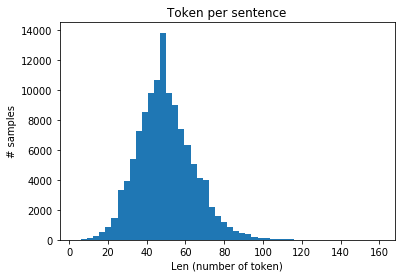

In [16]:
# Custom Tokenizer
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

# Plot sentence by lenght
plt.hist([len(tokenize(s)) for s in data['description'].values], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [17]:
# Train features
description_train = data['description'][:train_size]
variety_train = data['variety'][:train_size]

# Train labels
labels_train = data['price'][:train_size]

# Test features
description_test = data['description'][train_size:]
variety_test = data['variety'][train_size:]

# Test labels
labels_test = data['price'][train_size:]

## Wide Representation: BoW

The Code below will encode the description of each sentence using the [BoW model](https://en.wikipedia.org/wiki/Bag-of-words_model). This representation will encode each sentence to a vector that keep track of the entries in the vocabulary which are used in the current sentences. This step will build a sparse vector(a vector with mostly zero values) for each description. The Code provides an example to help you get the intuition behind it.

The **wide** term used for defining this model, is due to the sparse representation that this type of encoding carried out.

In [18]:
print("First Original Sample:", data['description'].values[0])
# Create a tokenizer to preprocess our text descriptions
tokenizer = keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, char_level=False)
tokenizer.fit_on_texts(description_train) # only fit on train

# Wide feature 1: sparse bag of words (bow) vocab_size vector 
description_bow_train = tokenizer.texts_to_matrix(description_train)
description_bow_test = tokenizer.texts_to_matrix(description_test)
print("\nFirst Sample after BoW (sparse representation truncated at the first 100 vocabulary terms):", description_bow_train[0][:100])

# Wide feature 2: one-hot vector of variety categories
# Use sklearn utility to convert label strings to numbered index
encoder = LabelEncoder()
encoder.fit(variety_train)
variety_train = encoder.transform(variety_train)
variety_test = encoder.transform(variety_test)
num_classes = np.max(variety_train) + 1

# Convert labels to one hot
variety_train = keras.utils.to_categorical(variety_train, num_classes)
variety_test = keras.utils.to_categorical(variety_test, num_classes)

First Original Sample: A soft acetone streak permeates the red cherry- and berry-driven bouquet, while red fruit and pomegranate flavors dominate the palate. A slightly twiggy herbal accent adds depth and staying power to the finish. Drink now.

First Sample after BoW (sparse representation truncated at the first 100 vocabulary terms): [0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0.
 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


## Wide Model

The model will use the BoW representation for the *winde description* and One-Hot encoding representation for the *wine variety* as Features for the Wide Model (a 2 layers NN).

![wide](images/wide.png)

*Image from the [paper](https://arxiv.org/pdf/1606.07792.pdf)*

In [19]:
# Define our wide model with the functional API
bow_inputs = layers.Input(shape=(VOCAB_SIZE,))
variety_inputs = layers.Input(shape=(num_classes,))
merged_layer = layers.concatenate([bow_inputs, variety_inputs])
merged_layer = layers.Dense(256, activation='relu')(merged_layer)
predictions = layers.Dense(1)(merged_layer)
wide_model = keras.Model(inputs=[bow_inputs, variety_inputs], outputs=predictions)

wide_model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
print(wide_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1040)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 256)          266496      concatenate_1[0][0]              
__________

## Deep Representation: Embedding

The Code below will encode the description of each sentence using [Word Embedding](https://en.wikipedia.org/wiki/Word_embedding). This representation will encode each word of the sentence into a vector. Before applying this encoding we need to preprocess the wine description by converting each token to an index and pad the sentence to the same lenght.

In [20]:
print("First Original Sample:", data['description'].values[0])

# Deep model feature: word embeddings of wine descriptions
train_embed = tokenizer.texts_to_sequences(description_train)
test_embed = tokenizer.texts_to_sequences(description_test)

train_embed = keras.preprocessing.sequence.pad_sequences(
    train_embed, maxlen=MAX_LEN, padding="post")
test_embed = keras.preprocessing.sequence.pad_sequences(
    test_embed, maxlen=MAX_LEN, padding="post")

print("\nFirst Sample after Preprocessing for Embedding:", train_embed[0])

First Original Sample: A soft acetone streak permeates the red cherry- and berry-driven bouquet, while red fruit and pomegranate flavors dominate the palate. A slightly twiggy herbal accent adds depth and staying power to the finish. Drink now.

First Sample after Preprocessing for Embedding: [  3  45 506   2  41  19   1  44 428 262  75  41  13   1 685   8 604   2
  24   3 136 115 758 379 313   1 296  11   2  18  32  38   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0]


## Deep Model

This model build a liner layer at the top of the word embedding representaion of the wine description. 

![deep](images/deep.png)

*Image from the [paper](https://arxiv.org/pdf/1606.07792.pdf)*

In [21]:
# Define our deep model with the Functional API
deep_inputs = layers.Input(shape=(MAX_LEN,))
embedding = layers.Embedding(VOCAB_SIZE, EMBEDDING, input_length=MAX_LEN)(deep_inputs)
embedding = layers.Flatten()(embedding)
embed_out = layers.Dense(1)(embedding)
deep_model = keras.Model(inputs=deep_inputs, outputs=embed_out)
print(deep_model.summary())

deep_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 170)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 170, 8)            8000      
_________________________________________________________________
flatten_1 (Flatten)          (None, 1360)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1361      
Total params: 9,361
Trainable params: 9,361
Non-trainable params: 0
_________________________________________________________________
None


## Wide & Deep Model

We will implement a model similar to Heng-Tze Cheng’s [Wide & Deep Learning for Recommender Systems](https://arxiv.org/pdf/1606.07792.pdf). 

This model catenate the output of the previous models and build an additional linear layer at the top.

![wide & deep](images/wide&deep.png)

*Image from the [paper](https://arxiv.org/pdf/1606.07792.pdf)*

In [22]:
# Combine wide and deep into one model
merged_out = layers.concatenate([wide_model.output, deep_model.output])
merged_out = layers.Dense(1)(merged_out)
combined_model = keras.Model(wide_model.input + [deep_model.input], merged_out)
print(combined_model.summary())

combined_model.compile(loss='mse',
                       optimizer='adam',
                       metrics=['accuracy'])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1000)         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 40)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 170)          0                                            
__________________________________________________________________________________________________
concatenate_1 (Concatenate)     (None, 1040)         0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________

## Train& Eval

The Training is defined at the beginning by the type of instance on which runs:

- On a CPU instance it will train for 10 epoch in about 1 minute.
- On a GPU instance it will train for 10 epoch in about 30 seconds.

In [23]:
# Run training
combined_model.fit([description_bow_train, variety_train] + [train_embed], labels_train, epochs=EPOCHS, batch_size=BATCH_SIZE)

Epoch 1/10
95646/95646 [==============================] - 8s 80us/step - loss: 1173.5215 - acc: 0.0264
Epoch 2/10
95646/95646 [==============================] - 7s 73us/step - loss: 1004.0753 - acc: 0.0315
Epoch 3/10
95646/95646 [==============================] - 7s 73us/step - loss: 956.9435 - acc: 0.0328
Epoch 4/10
95646/95646 [==============================] - 7s 75us/step - loss: 909.4029 - acc: 0.0349
Epoch 5/10
95646/95646 [==============================] - 7s 74us/step - loss: 856.2370 - acc: 0.0343
Epoch 6/10
95646/95646 [==============================] - 7s 74us/step - loss: 801.5227 - acc: 0.0359
Epoch 7/10
95646/95646 [==============================] - 7s 74us/step - loss: 744.3661 - acc: 0.0361
Epoch 8/10
95646/95646 [==============================] - 7s 74us/step - loss: 688.6710 - acc: 0.0362
Epoch 9/10
95646/95646 [==============================] - 7s 73us/step - loss: 632.3834 - acc: 0.0359
Epoch 10/10
95646/95646 [==============================] - 7s 73us/step - loss: 

In [25]:
combined_model.evaluate([description_bow_test, variety_test] + [test_embed], labels_test, batch_size=BATCH_SIZE)

23912/23912 [==============================] - 1s 22us/step


[799.7232393103326, 0.034961525596959926]

In [43]:
from ipywidgets import interact
from ipywidgets import widgets

def evaluate(num_predictions):
    # Generate predictions
    predictions = combined_model.predict([description_bow_test, variety_test] + [test_embed])

    # Compare predictions with actual values for the first few items in our test dataset
    diff = 0
    for i in range(num_predictions):
        val = predictions[i]
        print('[{}] - {}'.format(i+1, description_test.iloc[i]))
        print('Predicted: ', val[0], 'Actual: ', labels_test.iloc[i], '\n')
        diff += abs(val[0] - labels_test.iloc[i])

    # Compare the average difference between actual price and the model's predicted price
    print('Average prediction difference: ', diff / num_predictions)

interact(evaluate, num_predictions=widgets.IntSlider(value=1, min=1, max=20, description='# of test to evaluate/show'));

interactive(children=(IntSlider(value=1, description='# of test to evaluate/show', max=20, min=1), Output()), …

## It's your turn

In [62]:
# Let's make predictions on some raw data

# Enter wine descriptions here
test_descriptions = [
    'From 18-year-old vines, this supple well-balanced effort blends flavors of mocha, cherry, vanilla and breakfast tea. Superbly integrated and delicious even at this early stage, this wine seems destined for a long and savory cellar life. Drink now through 2028.',
    'The Quarts de Chaume, the four fingers of land that rise above the Layon Valley, are one of the pinnacles of sweet wines in the Loire. Showing botrytis and layers of dryness over the honey and peach jelly flavors, but also has great freshness. The aftertaste just lasts.',
    'Nicely oaked blackberry, licorice, vanilla and charred aromas are smooth and sultry. This is an outstanding wine from an excellent year. Forward barrel-spice and mocha flavors adorn core blackberry and raspberry fruit, while this runs long and tastes vaguely chocolaty on the velvety finish. Enjoy this top-notch Tempranillo through 2030.',
    'Bright, light oak shadings dress up this medium-bodied wine, complementing the red cherry and strawberry flavors. Its fresh, fruity and not very tannic—easy to drink and enjoy.',
    'This wine features black cherry, blackberry, blueberry with aromas of black licorice and earth. Ending with a creamy vanilla finish.'
]

# Enter the corresponding varieties here
test_varieties = [
    'Pinot Noir',
    'Chenin Blanc',
    'Tempranillo',
    'Sauvignon Blanc',
    'Syrah'
]

# Enter the corresponding prices here
labels = [
    48,
    152,
    80,
    10,
    23
]

# Wide model features
bow_description = tokenizer.texts_to_matrix(test_descriptions)
variety = encoder.transform(test_varieties)
print(variety[4])
variety = keras.utils.to_categorical(variety, len(encoder.classes_))

# Print an example for the model inputs
# print("Bag of words matrix")
# print(bow_description[0], "\n")
# print("Variety matrix")
# print(variety[0], "\n")

# Deep model feature: word embeddings of wine descriptions
embed_description = tokenizer.texts_to_sequences(test_descriptions)
print(embed_description[4])
embed_description = keras.preprocessing.sequence.pad_sequences(
    embed_description, maxlen=MAX_LEN, padding="post")



predictions = combined_model.predict([bow_description, variety] + [embed_description])
for i in range(len(test_descriptions)):
    val = predictions[i]
    print(test_descriptions[i])
    print('Predicted: ', val[0], 'Actual: ', labels[i], '\n')

34
[6, 9, 475, 27, 19, 50, 299, 5, 20, 4, 27, 147, 1, 193, 5, 3, 140, 51, 18]
From 18-year-old vines, this supple well-balanced effort blends flavors of mocha, cherry, vanilla and breakfast tea. Superbly integrated and delicious even at this early stage, this wine seems destined for a long and savory cellar life. Drink now through 2028.
Predicted:  46.473076 Actual:  48 

The Quarts de Chaume, the four fingers of land that rise above the Layon Valley, are one of the pinnacles of sweet wines in the Loire. Showing botrytis and layers of dryness over the honey and peach jelly flavors, but also has great freshness. The aftertaste just lasts.
Predicted:  55.323677 Actual:  152 

Nicely oaked blackberry, licorice, vanilla and charred aromas are smooth and sultry. This is an outstanding wine from an excellent year. Forward barrel-spice and mocha flavors adorn core blackberry and raspberry fruit, while this runs long and tastes vaguely chocolaty on the velvety finish. Enjoy this top-notch Temp

We have prepared some custom descriptions for testing. Run the code Cell below and type your wine description and variety in the widget, have fun :)

- **Description**: 'From 18-year-old vines, this supple well-balanced effort blends flavors of mocha, cherry, vanilla and breakfast tea. Superbly integrated and delicious even at this early stage, this wine seems destined for a long and savory cellar life. Drink now through 2028.', **Variety**: 'Pinot Noir'.
- **Description**: 'The Quarts de Chaume, the four fingers of land that rise above the Layon Valley, are one of the pinnacles of sweet wines in the Loire. Showing botrytis and layers of dryness over the honey and peach jelly flavors, but also has great freshness. The aftertaste just lasts.', **Variety**: 'Chenin Blanc'.
- **Description**: 'Nicely oaked blackberry, licorice, vanilla and charred aromas are smooth and sultry. This is an outstanding wine from an excellent year. Forward barrel-spice and mocha flavors adorn core blackberry and raspberry fruit, while this runs long and tastes vaguely chocolaty on the velvety finish. Enjoy this top-notch Tempranillo through 2030.', **Variety**: 'Tempranillo'.
- **Description**: 'Bright, light oak shadings dress up this medium-bodied wine, complementing the red cherry and strawberry flavors. Its fresh, fruity and not very tannic—easy to drink and enjoy.', **Variety**: 'Sauvignon Blanc'.
- **Description**: 'This wine features black cherry, blackberry, blueberry with aromas of black licorice and earth. Ending with a creamy vanilla finish.', **Variety**: 'Syrah'.

In [69]:
from ipywidgets import interact_manual
from ipywidgets import widgets


def get_prediction(test_description, test_variety):
    # Wide model features
    bow_description = tokenizer.texts_to_matrix([test_description])
    variety = encoder.transform([test_variety])
    variety = keras.utils.to_categorical(variety, len(encoder.classes_))
    
    # Deep model feature: word embeddings of wine descriptions
    embed_description = tokenizer.texts_to_sequences([test_description])
    embed_description = keras.preprocessing.sequence.pad_sequences(
        embed_description, maxlen=MAX_LEN, padding="post")
    

    # Evaluate
    predictions = combined_model.predict([bow_description, variety] + [embed_description])
    print(test_description)
    print('Predicted: ', predictions[0][0])
    
interact_manual(get_prediction, 
                test_description=widgets.Textarea(placeholder='Type a wine Description here'),
                test_variety=widgets.Text(placeholder='Type a wine Variety here'));

interactive(children=(Textarea(value='', description='test_description', placeholder='Type a wine Description …

## Save your model

In [56]:
import pickle

# Saving Tokenizer
with open('models/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
 
# Saving Variety Encode
with open('models/encoder.pickle', 'wb') as handle:
    pickle.dump(encoder, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
# Saving Model Weight
combined_model.save_weights('models/wide_and_deep_weights.h5')